In [4]:
import argparse
import collections
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from utils import generate_random_pair, transitive_closure
from C_dec_trainer import Trainer
from model import DEC
from dataset import GeneralDataset, MLDataset, CLDataset

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# prepare data
table = pd.read_csv('data/IMMU_scvi_embeddings.csv')
table = table[table['cell_type'] != 'undefined']

data = table.iloc[:, 0:20].values
batch_id = table.iloc[:, 21].values
cell_type = table.iloc[:, 20].values

label_encoder = LabelEncoder()
cell_type = label_encoder.fit_transform(cell_type)
cell_type_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

num_constraints = 4000
ml_ind1, ml_ind2, cl_ind1, cl_ind2 = generate_random_pair(cell_type, num_constraints*2)
ml_ind1, ml_ind2, cl_ind1, cl_ind2 = transitive_closure(ml_ind1, ml_ind2, cl_ind1, cl_ind2, data.shape[0])

ml_ind1 = ml_ind1[:num_constraints]
ml_ind2 = ml_ind2[:num_constraints]
cl_ind1 = cl_ind1[:num_constraints]
cl_ind2 = cl_ind2[:num_constraints]

train_dataset = GeneralDataset(data, cell_type)
ml_dataset = MLDataset(ml_ind1, ml_ind2, data)
cl_dataset = CLDataset(cl_ind1, cl_ind2, data)

dec_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=256)
eva_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=256)
ml_dataloader = DataLoader(ml_dataset, shuffle=True, batch_size=128)
cl_dataloader = DataLoader(cl_dataset, shuffle=True, batch_size=128)

# build model
idea_model = DEC(input_dim=20, latent_dim=10, n_clusters=7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
idea_model = idea_model.to(device)

trainable_params = list(filter(lambda p: p.requires_grad, idea_model.autoencoder.parameters())) 
pretrain_optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
cluster_optimizer = torch.optim.Adam(idea_model.parameters(), lr=1e-4)

trainer = Trainer(idea_model, 
                    cluster_optimizer, 
                    pretrain_optimizer, 
                    dec_dataloader, 
                    ml_dataloader, 
                    cl_dataloader, 
                    eva_dataloader,
                    device)

trainer.train()
predicted_labels, true_labels, acc, ari, nmi = trainer.evaluate()

预训练完成

使用K-Means初始化聚类中心...
K-Means初始化完成
1 pairwise train
1: ACC=0.4938, ARI=0.3820, NMI=0.4123
Change ratio: 100.00%
2 pairwise train
2: ACC=0.5287, ARI=0.4326, NMI=0.4461
Change ratio: 8.38%
3 pairwise train
3: ACC=0.6078, ARI=0.5811, NMI=0.4884
Change ratio: 13.27%
4 pairwise train
4: ACC=0.6167, ARI=0.5977, NMI=0.5052
Change ratio: 5.09%
5 pairwise train
5: ACC=0.6292, ARI=0.6040, NMI=0.5153
Change ratio: 3.74%
6 pairwise train
6: ACC=0.6379, ARI=0.6114, NMI=0.5262
Change ratio: 2.62%
7 pairwise train
7: ACC=0.6441, ARI=0.6197, NMI=0.5369
Change ratio: 1.65%
8 pairwise train
8: ACC=0.6489, ARI=0.6246, NMI=0.5450
Change ratio: 1.37%
9 pairwise train
9: ACC=0.6516, ARI=0.6273, NMI=0.5496
Change ratio: 1.08%
10 pairwise train
10: ACC=0.6554, ARI=0.6323, NMI=0.5563
Change ratio: 1.22%
11 pairwise train
11: ACC=0.6579, ARI=0.6348, NMI=0.5614
Change ratio: 1.01%
12 pairwise train
12: ACC=0.6595, ARI=0.6379, NMI=0.5646
Change ratio: 1.02%
13 pairwise train
13: ACC=0.6603, ARI=0.6393, NMI=0

In [5]:
idea_model.eval()
all_preds = []
all_labels = []
all_z = []

with torch.no_grad():
    for batch_data in dec_dataloader:
        x, y = batch_data
        x = x.to(device)
        q, z, out = idea_model(x)

        all_z.append(z.cpu().numpy())
        all_preds.append(q.cpu().numpy())
        all_labels.append(y.cpu().numpy())

preds = np.vstack(all_preds)
true_labels = np.concatenate(all_labels, axis=0)
embedding = np.vstack(all_z)

# Predict cluster assignments
predicted_labels = np.argmax(preds, axis=1)

/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


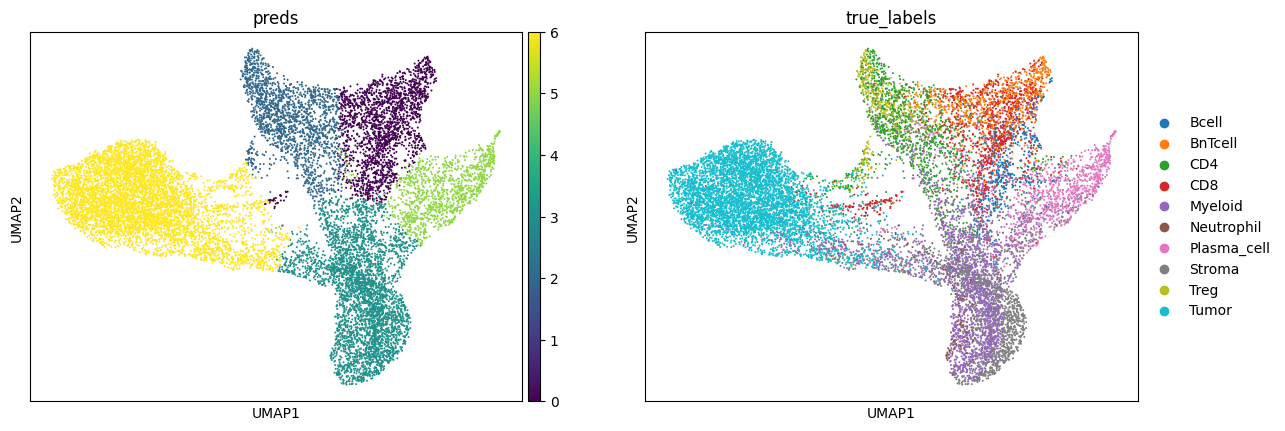

In [6]:
import scanpy as sc

adata = sc.AnnData(embedding)
adata.obs['preds'] = predicted_labels
true_labels = [cell_type_mapping[i] for i in true_labels]
adata.obs['true_labels'] = true_labels
sc.pp.subsample(adata, fraction=0.3)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['preds', 'true_labels'])